# SOBOL

In this notebook SOBOL analysis is performed on the found policies of the MORO. 

Input: ANALYSIS_results/03_MORO_results.csv

Output: ANALYSIS_results/04_sobol_results.tar.gz


In [8]:
#impot librariesr
import pandas as pd
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, prim
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model, MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           perform_experiments, Policy, Scenario)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench.util.utilities import (save_results, load_results)
import seaborn as sns
import matplotlib.pyplot as plt
from SALib.analyze import sobol

# SOBOL

In [ ]:
# get results from MORO
result_MORO = pd.read_csv('ANALYSIS_results/03_MORO_results.csv')

In [ ]:
# get policies
policies = result_MORO[['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']]
policies_list = [Policy(str(index), **row.to_dict()) for index, row in policies.iterrows()]

In [4]:
# define problem formulation
model, functions = get_model_for_problem_formulation(2)

In [ ]:
# run model using sobol sampling
ema_logging.log_to_stderr(ema_logging.INFO)


with MultiprocessingEvaluator(model) as evaluator:
    experiment, result = evaluator.perform_experiments(
                                         scenarios=1200,
                                         policies = policies_list, 
                                         uncertainty_sampling='sobol')

In [ ]:
# save results
results = experiment, result
save_results(results, 'ANALYSIS_results/04_sobol_results.tar.gz')

# Salib and visualisation

In [61]:
# load results
experiment, result = load_results('ANALYSIS_results/04_sobol_results.tar.gz')

In [62]:
# speficy SA lib problem
SA_lib_problem = get_SALib_problem(model.uncertainties)

In [64]:
experiment_2 = pd.concat([experiment, pd.DataFrame(result)], axis=1)

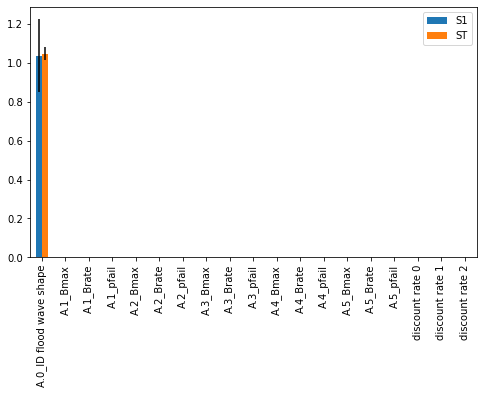

In [65]:
# SOBOL results for first policy
Si = sobol.analyze(SA_lib_problem, experiment_2[experiment_2['policy'] == 0]['Minimum water level full network'].to_numpy())
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df_1 = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df_1[['S1', 'ST']]
err = Si_df_1[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

In [28]:
pd.DataFrame(result).columns.to_list()

['Expected Annual Damage',
 'Dike Investment Costs',
 'RfR Investment Costs',
 'Evacuation Costs',
 'Expected Number of Deaths',
 'Minimum water level full network']

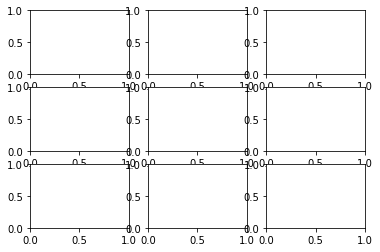

In [30]:
fig, ax = plt.subplots(3,3)

<AxesSubplot:>

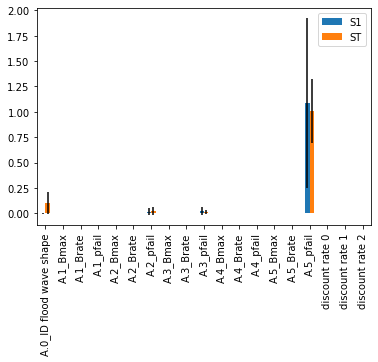

In [43]:
Si = sobol.analyze(SA_lib_problem, experiment_2[experiment_2['policy'] == 0]['Expected Number of Deaths'].to_numpy())
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df_1 = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df_1[['S1', 'ST']]
err = Si_df_1[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)

C:\Users\flori\Anaconda3\envs\epa1361\lib\site-packages\SALib\analyze\sobol.py:137: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\flori\Anaconda3\envs\epa1361\lib\site-packages\SALib\analyze\sobol.py:137: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\flori\Anaconda3\envs\epa1361\lib\site-packages\SALib\analyze\sobol.py:143: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\flori\Anaconda3\envs\epa1361\lib\site-packages\SALib\analyze\sobol.py:143: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\flori\Anaconda3\envs\epa1361\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scal

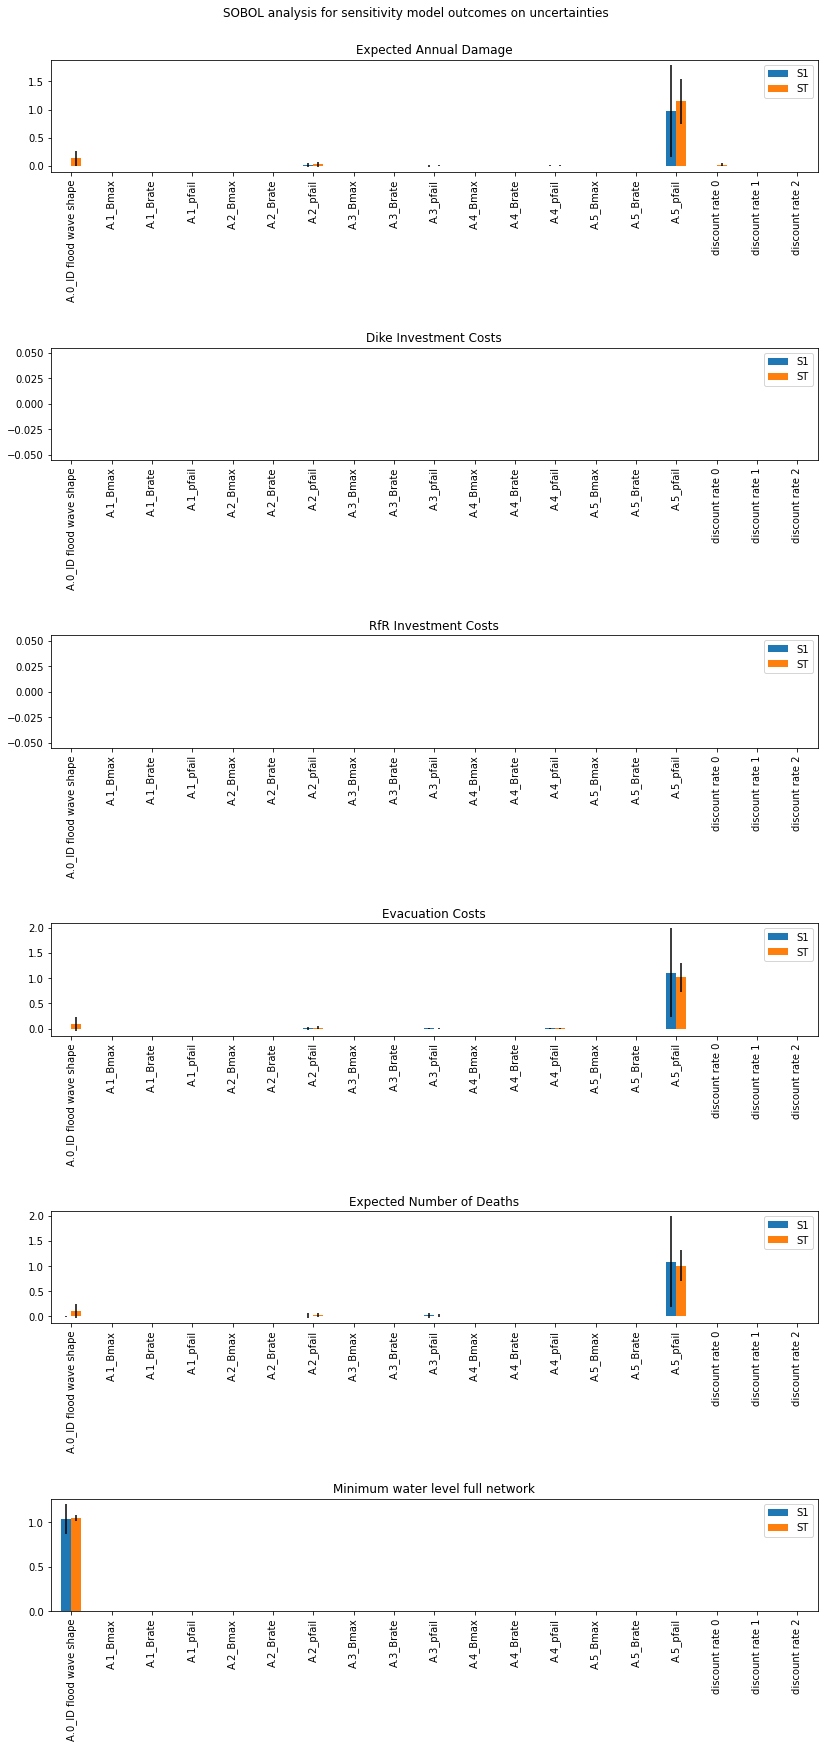

In [87]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=(12, 25))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
i = 0

for outcome in pd.DataFrame(result).columns.to_list():
    Si = sobol.analyze(SA_lib_problem, experiment_2[experiment_2['policy'] == 0][outcome].to_numpy())
    scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df_1 = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
    indices = Si_df_1[['S1', 'ST']]
    err = Si_df_1[['S1_conf', 'ST_conf']]
    indices.plot.bar(yerr=err.values.T, ax=axes[i])
    axes[i].set_title(outcome)
    i += 1
fig.suptitle('SOBOL analysis for sensitivity model outcomes on uncertainties')
fig.tight_layout(pad=3.0)

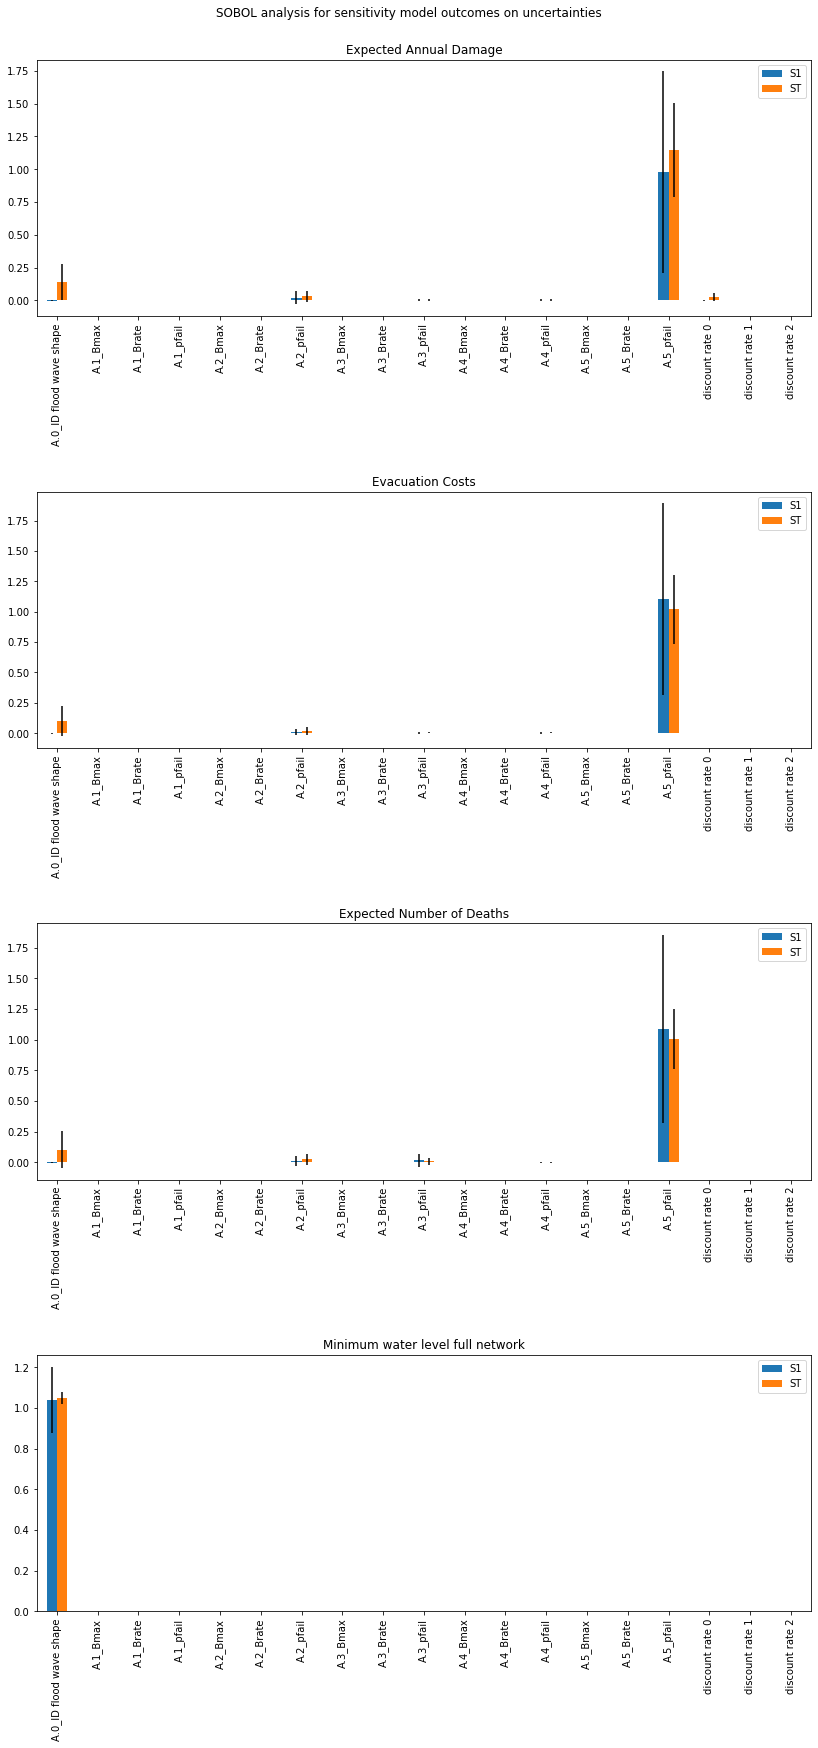

In [90]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12, 25))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
i = 0

for outcome in ['Expected Annual Damage',
 'Evacuation Costs',
 'Expected Number of Deaths',
 'Minimum water level full network']:
    Si = sobol.analyze(SA_lib_problem, experiment_2[experiment_2['policy'] == 0][outcome].to_numpy())
    scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df_1 = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
    indices = Si_df_1[['S1', 'ST']]
    err = Si_df_1[['S1_conf', 'ST_conf']]
    indices.plot.bar(yerr=err.values.T, ax=axes[i])
    axes[i].set_title(outcome)
    i += 1
fig.suptitle('SOBOL analysis for sensitivity model outcomes on uncertainties')
fig.tight_layout(pad=3.0)